## Split Audio

In [1]:
from pydub import AudioSegment
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
inputDirectory = '../cracklesinput/Respiratory_Sound_Database/audio_and_txt_files'

In [3]:
def split_and_read(filename, audioFile, metaDataFile, sample_rate=22000):
    """
    Read .wav file, split all breaths, and resample to a fixed sample rate for uniformity
    Params - 
    filename: name of wav file
    audioPath: path to wav file
    metaDataPath: path to txt file containing the start and end times for each breath
    
    Returns - 
    List containg arrays corresponding to each breath in wav file of format:(resampled data of one breath in in wav file of size (length of breath in seconds*sample rate), length of breath in seconds, if the breath contains coarse crackles, if the breath contains fine crackles)
    """
    print('working on audio: ' + audioFile + ' and metafile: ' + metaDataFile)
    recording_annotations = pd.read_csv(metaDataFile,
                                        names=['Start', 'End', 'Coarse', 'Fine'], delimiter='\t')

    recording_audio = AudioSegment.from_wav(audioFile)
    data = [filename]
    print(len(recording_annotations.index))

    for i in range(len(recording_annotations.index)):
        
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        coarse = int(row['Coarse'])
        fine = int(row['Fine'])
        
        audio_chunk = recording_audio[int(start*1000) : int(end*1000)]
        
        if ((coarse == 1) & (fine == 0)):
            if_coarse = True
            if_fine = False
        elif (coarse == 0) & (fine == 1):
            if_coarse = False
            if_fine = True
        elif (coarse == 0) & (fine == 0):
            if_coarse = False
            if_fine = False
        else :  # Not enough files in both fine and coarse, so not considering further
            if_coarse = True
            if_fine = True
            
        
        samples = audio_chunk.get_array_of_samples()
        audio_chunk_data = np.array(samples).astype(np.float32)/32768 # convert 24 bit wav file to 16 bit
        audio_chunk_resampled = librosa.resample(audio_chunk_data, audio_chunk.frame_rate, sample_rate, res_type='kaiser_best')
        
        data.append([audio_chunk_resampled, len(audio_chunk), if_coarse, if_fine])
        
        print ("length of audio: " ,len(audio_chunk))
        
    return data

In [4]:
all_breath_list = []
breath_lengths = []
for filename in os.listdir(inputDirectory):
    if filename.endswith(".wav"):
        audioFile = os.path.join(inputDirectory, filename)
        metaDataFile = os.path.join(inputDirectory, filename.replace(".wav",".txt"))
        data = split_and_read(filename, audioFile, metaDataFile)
        breath_chunk_data = [(d[0], d[2], d[3]) for d in data[1:]]
        all_breath_list.extend(breath_chunk_data)
        breath_lengths.extend((d[1]) for d in data[1:])
    else:
        continue

working on audio: ../cracklesinput/Respiratory_Sound_Database/audio_and_txt_files/223_1b1_Ll_sc_Meditron.wav and metafile: ../cracklesinput/Respiratory_Sound_Database/audio_and_txt_files/223_1b1_Ll_sc_Meditron.txt
10
length of audio:  2828
length of audio:  3164
length of audio:  3187
length of audio:  3266
length of audio:  3005
length of audio:  3298
length of audio:  3015
length of audio:  3240
length of audio:  3598
length of audio:  2490
working on audio: ../cracklesinput/Respiratory_Sound_Database/audio_and_txt_files/216_1b1_Al_sc_Meditron.wav and metafile: ../cracklesinput/Respiratory_Sound_Database/audio_and_txt_files/216_1b1_Al_sc_Meditron.txt
12
length of audio:  1228
length of audio:  1355
length of audio:  1716
length of audio:  1686
length of audio:  1643
length of audio:  2453
length of audio:  2456
length of audio:  1410
length of audio:  1154
length of audio:  1746
length of audio:  1952
length of audio:  1164
working on audio: ../cracklesinput/Respiratory_Sound_Databas

In [5]:
len(all_breath_list)

253

In [7]:
none=[]
coarse=[]
fine=[]
for breath in all_breath_list:
    if (breath[1] == False) & (breath[2] == False):
        none.append(breath)
    elif (breath[1] == True) & (breath[2] == False):
        coarse.append(breath)
    elif (breath[1] == False) & (breath[2] == True):
        fine.append(breath)


longest breath:  6.411 seconds
shortest breath: 0.286 seconds
Petcentage of breaths less than  5  seconds long: 0.9762845849802372 %


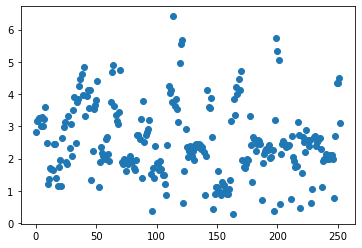

In [8]:
breath_len_arr = np.array(breath_lengths)/1000
plt.plot(breath_len_arr, 'o')
print('longest breath: ',max(breath_len_arr), "seconds")
print('shortest breath:', min(breath_len_arr), "seconds")
breath_lenght = 5
print('Petcentage of breaths less than ', breath_lenght, ' seconds long:', np.sum(breath_len_arr < breath_lenght)/len(breath_len_arr), '%')

## Split into test and train datasets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_val_ratio = 0.2

In [11]:
none_train, none_test = train_test_split(none, test_size = train_val_ratio, random_state=10)
coarse_train, coarse_test  = train_test_split(coarse, test_size = train_val_ratio, random_state=10)
fine_train, fine_test  = train_test_split(fine, test_size = train_val_ratio, random_state=10)

In [12]:
print("Total number of files: ", len(all_breath_list))
print("Train files:")
print("None: ", len(none_train))
print("Coarse crackles: ", len(coarse_train))
print("Fine Crackles: ", len(fine_train))
print("Test files:")
print("None: ", len(none_test))
print("Coarse crackles: ", len(coarse_test))
print("Fine Crackles: ", len(fine_test))

Total number of files:  253
Train files:
None:  47
Coarse crackles:  70
Fine Crackles:  84
Test files:
None:  12
Coarse crackles:  18
Fine Crackles:  21


## Process data

In [13]:
from sklearn.preprocessing import MinMaxScaler
import scipy.signal

In [14]:
def rand_stretch(sound, rate=np.random.uniform(low=0.5,high=1.5)):
    """
    Randomly squeeze or strech the sound array in the passed data and return the squeezed file
    Params - 
    sound: Array(soundData, if_coarse_flag, if_fine_flag)
    rate: constaints for how much to stretch or sqeeze the file. Default: squeeze or strech so that the new file is 0.5 to 1.5 the speed of the original
    
    Returns - 
    Array(squeezed file, if_coarse_flag, if_fine_flag)
    """
    stretched_sound = librosa.effects.time_stretch(sound, rate)
    return stretched_sound

def stretch_breaths_list(data_list, repeat, append_fraction=1):
    """
    Do rand_stretch for a list of arays to be passed to rand_stretch
    Params - 
    data_list: list of arrays to be passed to rand_stretch
    repeat: How many time to pass list to rand_stretch. Essetially, the number of times to mulitply the number of sound arrays by 2
    append_fraction: fraction of data_list to randomly sample data_list and pass the sampled list to rand_stretch. By default takes the whole data_list
    """
    sound_list = [d[0] for d in data_list]
    np.random.shuffle(sound_list)
    count = int(len(sound_list) * (1-append_fraction))
    sound_list = sound_list[count:]
    if_coarse = [d[1] for d in data_list]
    if_fine = [d[2] for d in data_list]
    streched_data_list = []
    streched_data_list.extend(data_list)
    for i in range(0, repeat):
        stretched = []
        for sound in sound_list:
            stretched.append((rand_stretch(sound), if_coarse[0], if_fine[0]))
        streched_data_list.extend(stretched)
    return streched_data_list

In [15]:
def resize(data, final_len_seconds, sample_rate=22000):
    """
    Resize the sound file passed to it to a particular size so that it can be trained. The model requires all the arrays to be trained to be the same size
    If the sound file is smaller than the requied lenght to be padded, copy it a whole number of times and pad the rest with zeros
    If the sound file is bigger than the required length, squeeze it till it is the right length
    Params - 
    data: Array(soundData, if_coarse_flag, if_fine_flag)
    final_len_seconds: length in seconds the file needs to be resized to
    sample_rate: current sample rate of the file
    
    Returns - 
    Array(ResizedSoundData, if_coarse_flag, if_fine_flag)
    
    """
    len_to_fill = int(final_len_seconds * sample_rate)
    sound = data[0]
    len_filled = len(sound)
    len_filled_seconds = len_filled / sample_rate 
    initial_sound = sound
    #print("len(initial_sound) ",len(initial_sound))
    if (len(initial_sound) < len_to_fill):
        for n in range(0, int(final_len_seconds//len_filled_seconds)-1):
            initial_sound=np.concatenate((initial_sound,sound), axis=0)
        #print ("len_to_fill " , len_to_fill)
        #print("len(initial_sound) after concatenate ",len(initial_sound))
        len_to_pad = len_to_fill-len(initial_sound)
        final_data = np.pad(initial_sound, [(0, len_to_pad)], mode='constant', constant_values=0)#Pad with zeros
    else:
        #print("greater")
        rate=len(initial_sound)/len_to_fill
        final_data = librosa.effects.time_stretch(initial_sound, rate)
    #print("final length ", len(final_data))
    return (final_data, data[1], data[2])

In [16]:
#His
def get_mel_filterbanks(sound_data, sample_rate, n_filters):
    n_rows = 175 # 7500 cutoff
    n_window = 512 #~25 ms window
    
    (f, t, Sxx) = scipy.signal.spectrogram(sound_data,fs = sample_rate, nfft= n_window, nperseg=n_window)
    
    Sxx = Sxx[:n_rows,:].astype(np.float32) #sift out coefficients above 7500hz, Sxx has 196 columns
    
    mel_log = FFT2MelSpectrogram(f[:n_rows], Sxx, sample_rate, n_filters)
    
    scaler = MinMaxScaler()
    scaler.fit(mel_log)
    scaler.data_max_
    norm_mel_log=scaler.transform(mel_log)
    
    return np.reshape(norm_mel_log, (n_filters,Sxx.shape[1],1)).astype(np.float32)

def Freq2Mel(freq):
    return 1125 * np.log(1 + freq / 700)

def Mel2Freq(mel):
    exponents = mel / 1125
    return 700 * (np.exp(exponents) - 1)

def GenerateMelFilterBanks(mel_space_freq, fft_bin_frequencies):
    n_filters = len(mel_space_freq) - 2
    coeff = []
    for mel_index in range(n_filters):
        m = int(mel_index + 1)
        filter_bank = []
        for f in fft_bin_frequencies:
            if(f < mel_space_freq[m-1]):
                hm = 0
            elif(f < mel_space_freq[m]):
                hm = (f - mel_space_freq[m-1]) / (mel_space_freq[m] - mel_space_freq[m-1])
            elif(f < mel_space_freq[m + 1]):
                hm = (mel_space_freq[m+1] - f) / (mel_space_freq[m + 1] - mel_space_freq[m])
            else:
                hm = 0
            filter_bank.append(hm)
        coeff.append(filter_bank)
    return np.array(coeff, dtype = np.float32)

def FFT2MelSpectrogram(f, Sxx, sample_rate, n_filterbanks):
    (max_mel, min_mel)  = (Freq2Mel(max(f)), Freq2Mel(min(f)))
    mel_bins = np.linspace(min_mel, max_mel, num = (n_filterbanks + 2))
    mel_freq = Mel2Freq(mel_bins)
        
    filter_banks = GenerateMelFilterBanks(mel_freq, f)
        
    mel_spectrum = np.matmul(filter_banks, Sxx)
    return np.log10(mel_spectrum  + float(10e-12))

In [17]:
def one_hot_encode(data):
    """
    One hot encode the data for training
    Params - 
    data: flags to one hot encode
    
    Returns - 
    one hot encoded label array
    """
    if (data[1] == False) & (data[2] == False):
        one_hot_label = np.array([1,0,0])
    elif (data[1] == True) & (data[2] == False):
        one_hot_label = np.array([0,1,0])
    elif (data[1] == False) & (data[2] == True):
        one_hot_label = np.array([0,0,1])
    return one_hot_label  

In [18]:
def resize_mel_and_onehot_list(data_list, final_len_seconds, sample_rate=22000):
    """
    Do resize, get_mel_filterbanks and one_hot_encode on a list of the arrays to be passes
    Params - 
    data_list: List of arrays to be passed
    final_len_seconds: Seconds to which all files in array have to be resized
    sample_rate: Sample rate of each array
    """
    final_list=[]
    for data in data_list:
        resized = resize(data, final_len_seconds, sample_rate)
        mel = get_mel_filterbanks(resized[0], sample_rate, 50)
        print(np.shape(mel))
        one_hot_label = one_hot_encode(data)
        final_list.append((mel, one_hot_label))
    return final_list

In [19]:
none_stretched_train=stretch_breaths_list(none_train, 5, 0.94)
coarse_stretched_train=stretch_breaths_list(coarse_train, 4, 0.72)
fine_stretched_train=stretch_breaths_list(fine_train, 3, 0.75)

In [20]:
none_final_train = resize_mel_and_onehot_list(none_stretched_train,5)
coarse_final_train = resize_mel_and_onehot_list(coarse_stretched_train,5)
fine_final_train = resize_mel_and_onehot_list(fine_stretched_train,5)

(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)

In [21]:
print("Train files:")
print("None: ", len(none_final_train))
print("Coarse crackles: ", len(coarse_final_train))
print("Fine Crackles: ", len(fine_final_train))

Train files:
None:  272
Coarse crackles:  274
Fine Crackles:  273


In [22]:
train_dict = {'none':none_final_train,'coarsecrackles':coarse_final_train,'finecrackles':fine_final_train}

In [23]:
none_stretched_train=stretch_breaths_list(none_train, 5, 0.94)
coarse_stretched_train=stretch_breaths_list(coarse_train, 4, 0.72)
fine_stretched_train=stretch_breaths_list(fine_train, 3, 0.75)

In [24]:
none_resize_test = resize_mel_and_onehot_list(none_stretched_train,5)
coarse_resize_test = resize_mel_and_onehot_list(coarse_stretched_train,5)
fine_resize_test = resize_mel_and_onehot_list(fine_stretched_train,5)

(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)

In [25]:
test_dict = {'none':none_resize_test,'coarsecrackles':coarse_resize_test,'finecrackles':fine_resize_test}

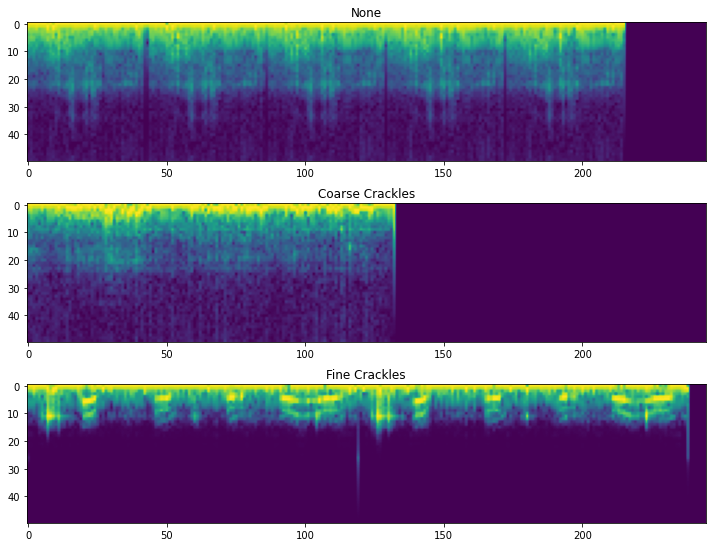

In [27]:
#Example of tiled sound samples
sample_height = train_dict['none'][0][0].shape[0]
sample_width = train_dict['none'][0][0].shape[1]
ind = 1
plt.figure(figsize = (10,10))
plt.subplot(4,1,1)
plt.imshow(train_dict['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(4,1,2)
plt.imshow(train_dict['coarsecrackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Coarse Crackles')
plt.subplot(4,1,3)
plt.imshow(train_dict['finecrackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Fine Crackles')
#plt.subplot(4,1,4)
#plt.imshow(train_dict['both'][ind][0].reshape(sample_height, sample_width))
#plt.title('Both')
plt.tight_layout()

## AutoKeras

In [28]:
def shuffle_together(sounds, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(sounds)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    return (sounds, labels)

In [29]:

none = [i[0] for i in train_dict['none']]
fine = [i[0] for i in train_dict['finecrackles']]
coarse = [i[0] for i in train_dict['coarsecrackles']]
none_l = [i[1] for i in train_dict['none']]
fine_l = [i[1] for i in train_dict['finecrackles']]
coarse_l = [i[1] for i in train_dict['coarsecrackles']]

In [30]:

none_t = [i[0] for i in test_dict['none']]
fine_t = [i[0] for i in test_dict['finecrackles']]
coarse_t = [i[0] for i in test_dict['coarsecrackles']]
none_lt = [i[1] for i in test_dict['none']]
fine_lt = [i[1] for i in test_dict['finecrackles']]
coarse_lt = [i[1] for i in test_dict['coarsecrackles']]

In [31]:
x_train = np.vstack((none, fine, coarse))
y_train = np.vstack((none_l, fine_l, coarse_l))
x_train,y_train = shuffle_together(x_train,y_train)

In [32]:
x_val = np.vstack((none_t, fine_t, coarse_t))
y_val = np.vstack((none_lt, fine_lt, coarse_lt))
x_val,y_val = shuffle_together(x_val,y_val)

In [33]:
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, BatchNormalization, Softmax, MaxPooling2D, Input
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Model
import tensorflow as tf

K.clear_session()

input_1 =  Input(shape=(50,245,1), dtype = "float32")

normalizatiion = preprocessing.Normalization(dtype = "float32")(tf.cast(input_1, tf.float32))

conv2d = Conv2D(32, kernel_size = [3,3], activation = "relu", kernel_initializer = "GlorotUniform", bias_initializer = "zeros", data_format = "channels_last", dtype = "float32")(normalizatiion)

conv2d_1 = Conv2D(64, kernel_size = [3,3], activation = "relu", kernel_initializer = "GlorotUniform", bias_initializer = "zeros", data_format = "channels_last", dtype = "float32")(conv2d)

max_pooling2d = MaxPooling2D(pool_size=(2, 2), data_format = "channels_last", dtype = "float32")(conv2d_1)

dropout = Dropout(rate = 0.25, dtype = "float32")(max_pooling2d)

flatten = Flatten(data_format = "channels_last", dtype = "float32")(dropout)

dropout_1 = Dropout(rate = 0.5, dtype = "float32")(flatten)

dense = Dense(3, activation = 'linear', dtype = "float32")(dropout_1)

classification_head_1 = Softmax(dtype = "float32")(dense)

model = Model(inputs = input_1, outputs = classification_head_1)

opt = optimizers.Adam(learning_rate=0.0010000000474974513, beta_1=0.8999999761581421, beta_2=0.9990000128746033, epsilon=float(1e-07), amsgrad=False)

model.compile(optimizer =  opt , loss = 'categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 245, 1)]      0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 50, 245, 1)        0         
_________________________________________________________________
normalization (Normalization (None, 50, 245, 1)        3         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 243, 32)       320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 241, 64)       18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 120, 64)       0     

In [34]:
batch_size = 32
epochs = 11

In [35]:
stats = model.fit(x_train, 
                  y_train,
                  #steps_per_epoch = len(x_train) // batch_size,
                  validation_data = (x_val, y_val),
                  validation_steps = len(x_val) // batch_size,
                  epochs=epochs
                 )

Epoch 1/11
26/26 [==============================] - 53s 2s/step - loss: 1.0473 - categorical_accuracy: 0.4349 - val_loss: 0.8654 - val_categorical_accuracy: 0.6178
Epoch 2/11
26/26 [==============================] - 40s 2s/step - loss: 0.7276 - categorical_accuracy: 0.6880 - val_loss: 0.4993 - val_categorical_accuracy: 0.8230
Epoch 3/11
26/26 [==============================] - 35s 1s/step - loss: 0.4277 - categorical_accuracy: 0.8685 - val_loss: 0.2868 - val_categorical_accuracy: 0.9121
Epoch 4/11
26/26 [==============================] - 30s 1s/step - loss: 0.1991 - categorical_accuracy: 0.9382 - val_loss: 0.1749 - val_categorical_accuracy: 0.9548
Epoch 5/11
26/26 [==============================] - 28s 1s/step - loss: 0.0737 - categorical_accuracy: 0.9842 - val_loss: 0.2110 - val_categorical_accuracy: 0.9267
Epoch 6/11
26/26 [==============================] - 29s 1s/step - loss: 0.0662 - categorical_accuracy: 0.9890 - val_loss: 0.1703 - val_categorical_accuracy: 0.9451
Epoch 7/11
26/26

Text(0.5, 1.0, 'Loss')

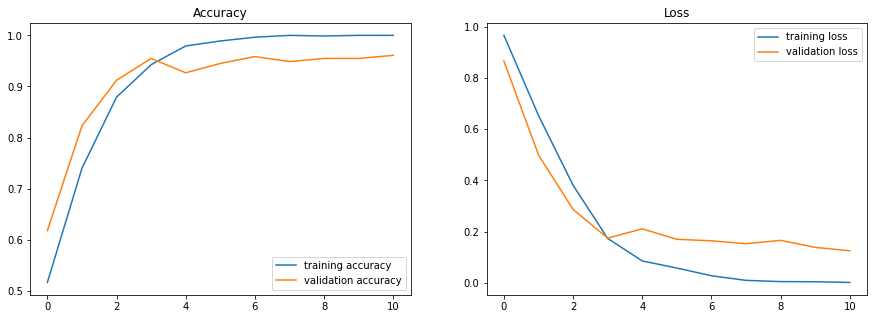

In [36]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['categorical_accuracy'], label = 'training accuracy')
plt.plot(stats.history['val_categorical_accuracy'], label = 'validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [37]:
import tensorflow as tf

In [39]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax((y_val), axis = 1)
predictions

array([2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 0, 0, 2, 1, 2, 2, 1, 2, 1, 0, 0,
       0, 2, 1, 0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 0, 1, 0, 2, 1, 0, 1, 0, 2,
       0, 0, 2, 2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 0, 2, 0, 1, 2, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 2, 2, 0, 1, 2, 2, 0, 0, 1, 2, 2, 1, 1, 1, 0, 2, 2, 0, 1,
       1, 0, 1, 2, 0, 2, 2, 2, 1, 0, 1, 0, 1, 0, 0, 2, 1, 0, 2, 1, 0, 0,
       2, 1, 1, 0, 0, 0, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 1, 1, 2,
       1, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0,
       2, 2, 1, 1, 0, 0, 1, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 2, 2, 1, 2,
       1, 2, 2, 1, 0, 0, 2, 1, 0, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 0, 1, 1,
       0, 2, 0, 0, 1, 2, 1, 2, 1, 0, 0, 2, 0, 1, 2, 1, 0, 1, 2, 1, 1, 2,
       2, 2, 2, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0, 0, 2,
       2, 0, 0, 1, 2, 2, 2, 1, 0, 2, 0, 0, 1, 0, 1, 2, 0, 1, 2, 2, 1, 1,
       0, 2, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0,

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','coarse crackles','fine crackles']))
cm = confusion_matrix(labels, predictions)
print(cm)

                 precision    recall  f1-score   support

           none       0.97      0.98      0.98       272
coarse crackles       0.95      0.96      0.95       274
  fine crackles       0.97      0.95      0.96       273

       accuracy                           0.96       819
      macro avg       0.96      0.96      0.96       819
   weighted avg       0.96      0.96      0.96       819

[[267   0   5]
 [  8 262   4]
 [  0  15 258]]


In [41]:
labels = ['none','coarse crackles','fine crackles']
cm_df = pd.DataFrame(cm, columns=labels, index=labels)

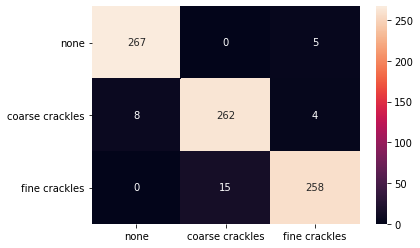

In [42]:
import seaborn as sns
ax = sns.heatmap(cm_df, annot=True, fmt='g')